<a href="https://colab.research.google.com/github/Jungsan005/Bigdata-Class/blob/master/%EC%84%9C%EC%9A%B8_%EB%B6%80%EB%8F%99%EC%82%B0%EB%A7%A4%EB%A7%A4_%EC%8B%9C%EA%B3%84%EC%97%B4_LSTM_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 데이터 불러오기
seoul = pd.read_csv('https://raw.githubusercontent.com/Jungsan005/Bigdata-Class/master/seoul.csv')
seoul.head(5)

,year,month,price
0,2010,1,497.6
1,2010,2,481.1
2,2010,3,478.7
3,2010,4,471.2
4,2010,5,475.0


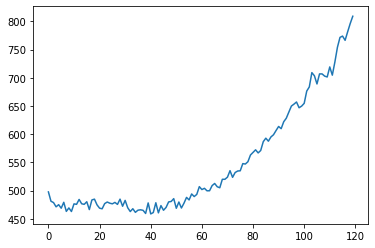

In [7]:
# 시각화로 데이터 확인
plt.plot(seoul.price)

In [9]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [10]:
# 랜덤 시드 설정
np.random.seed(2008072100)

In [19]:
# 평당 가격 데이터를 float32로 변환
dataset = seoul.price.to_numpy()
dataset = dataset.astype('float32')
dataset[:12]

array([497.6, 481.1, 478.7, 471.2, 475. , 468.7, 479.2, 463.1, 469.2,
       462.9, 476.4, 475.6], dtype=float32)

In [20]:
# 값의 범위를 0~1로 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
dataset[:12]

array([[0.11123788],
       [0.06417561],
       [0.05733025],
       [0.03593838],
       [0.04677689],
       [0.02880776],
       [0.05875635],
       [0.01283514],
       [0.03023386],
       [0.01226461],
       [0.05077004],
       [0.04848826]], dtype=float32)

In [21]:
# 7.5:2.5 비율로 훈련데이터와 테스트데이터 분리 
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

90 30


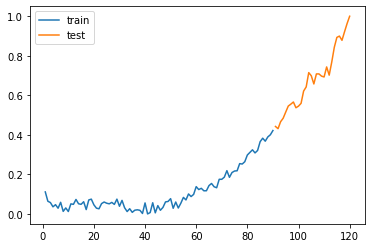

In [65]:
# 훈련데이터와 테스트데이터 시각화
x = len(train)+1
y = len(test)+1
df_train = pd.DataFrame(train, index=range(1, x))
df_test = pd.DataFrame(test, index=range(x, x+y-1) )

ax = df_train.plot()
df_test.plot(ax=ax)
plt.legend(['train', 'test'])

In [96]:
# X는 현재 시점(t)의 평당 가격이고, 
# Y는 다음 시점(t+1)의 평당 가격인 데이터 집합을 생성하는 함수 정의
def shift_dataset(dataset, shift=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-shift-1):
		a = dataset[i:(i+shift), 0]
		dataX.append(a)
		dataY.append(dataset[i + shift, 0])
	return np.array(dataX), np.array(dataY)

In [97]:
# train 데이터와 test 데이터에 대해 X, Y 컬럼 생성
shift = 1
X_train, y_train = shift_dataset(train, shift)
X_test, y_test = shift_dataset(test, shift)

In [98]:
# keras에서는 RNN 계열 모델을 훈련시킬때 
# 데이터는 반드시 3차원 형식이어야 하고 
# 각 차원은 (sample, timestep, feature) 로 구성되어야 함
# 일반적인 MLP 모델에서는 sample와 feature 등으로 구성되는 2차원 배열이지만,
# RNN에서는 "시간"이라는 개념이 포함되기 때문에 차원이 하나 더 늘어남

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [99]:
# keras를 이용해서 LSTM 모델 생성 
# 입력유형은 (timestep, feature) 
# 출력유형은 target의 갯수가 1이므로 Dense(1)을 추가함 
# 연속적인 값을 예측하는 것이기 때문에 손실함수는 mean squared error로 설정
# 최적화함수는 일반적으로 adam으로 설정
# 훈련 데이터를 100번 사용해서 학습을 실시함
# 훈련 데이터를 5개의 작은 조각batch들로 나누고 이 조각들을 순회하며 학습을 진행
# 따라서, 총 학습횟수는 이포크수 x (훈련데이터수 / 배치사이즈) 
# 학습시 훈련의 진행도를 보여주는 진행 막대를 보여줌

model = Sequential()
model.add(LSTM(4, input_shape=(1, shift)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0,
                    validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


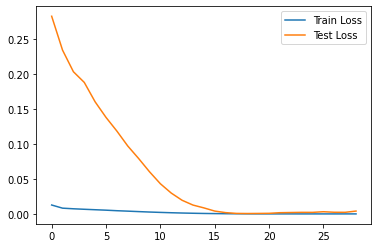

In [100]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [101]:
# 예측 실시
tr_pred = model.predict(X_train)
ts_pred = model.predict(X_test)

ts_pred[:12]

array([[0.4801558 ],
       [0.46715194],
       [0.5082551 ],
       [0.5290622 ],
       [0.56574196],
       [0.6018218 ],
       [0.61329234],
       [0.6261123 ],
       [0.59170187],
       [0.6014843 ],
       [0.6180155 ],
       [0.6914711 ]], dtype=float32)

In [102]:
# 0~1로 정규화했던 것을 원래의 값으로 환원
tr_pred = scaler.inverse_transform(tr_pred)
y_train = scaler.inverse_transform([y_train])

ts_pred = scaler.inverse_transform(ts_pred)
y_test = scaler.inverse_transform([y_test])

ts_pred[:12]

array([[626.9427 ],
       [622.38354],
       [636.79425],
       [644.08923],
       [656.94916],
       [669.59875],
       [673.6203 ],
       [678.115  ],
       [666.0507 ],
       [669.4804 ],
       [675.2763 ],
       [701.0298 ]], dtype=float32)

In [103]:
# 예측값에 대한 평균제곱오차 계산
tr_score = math.sqrt(mean_squared_error(y_train[0], tr_pred[:,0]))
print('Train Score: %.2f RMSE' % (tr_score))

ts_core = math.sqrt(mean_squared_error(y_test[0], ts_pred[:,0]))
print('Test Score: %.2f RMSE' % (ts_core))

Train Score: 9.03 RMSE
Test Score: 24.01 RMSE


In [104]:
# 시각화를 위해 훈련 예측데이터를 재조정
tr_pred_data = np.empty_like(dataset)
tr_pred_data[:, :] = np.nan
tr_pred_data[shift:len(tr_pred)+shift, :] = tr_pred

In [105]:
# 시각화를 위해 테스트 예측데이터를 재조정
ts_pred_data = np.empty_like(dataset)
ts_pred_data[:, :] = np.nan
ts_pred_data[len(tr_pred)+(shift*2)+1:len(dataset)-1, :] = ts_pred

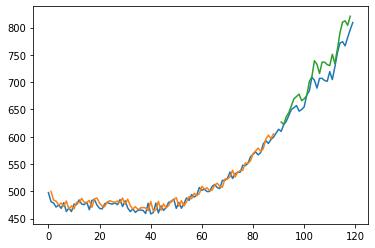

In [106]:
# 예측 결과 시각화
plt.plot(scaler.inverse_transform(dataset))

plt.plot(tr_pred_data)
plt.plot(ts_pred_data)